# American Sign Language Detection
## importing libraries 
    firstly we should import libraries which are necessary for the model to function and for other segments such as data processing , result visualization etc.

In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

## Data Loading and Preprocessing
    we define the data_dir variable to specify the directory containing the image dataset. We then load the image dataset using tf.keras.preprocessing.image_dataset_from_directory function. Following that, we filter out any corrupted images from the dataset by iterating over each folder and deleting the corrupted images.

In [4]:
data_dir = '/kaggle/input/asl-dataset/asl_dataset/asl_dataset/'

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 2515 files belonging to 36 classes.


In [62]:
# Filtering out corrupted images
import os
num_skipped = 0
for folder_name in ("0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"
                    ,"p","q","r","s","t","u","v","w","x","y","z"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 0 images


## Data Augmentation and Generator
    In this segment, we create an ImageDataGenerator object datagen for data augmentation. The datagen is configured with various augmentation parameters such as rotation, width and height shift, shear, zoom, and horizontal flip. The images are also rescaled by dividing by 255. We then specify the image dimensions, batch size, and image shape. Finally, we create separate data generators for training and validation using the flow_from_directory method, which loads the images from the specified directory, performs data augmentation, and provides the images and their corresponding labels.

In [63]:
# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

In [64]:
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [65]:

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.


In [66]:

num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 36 ....


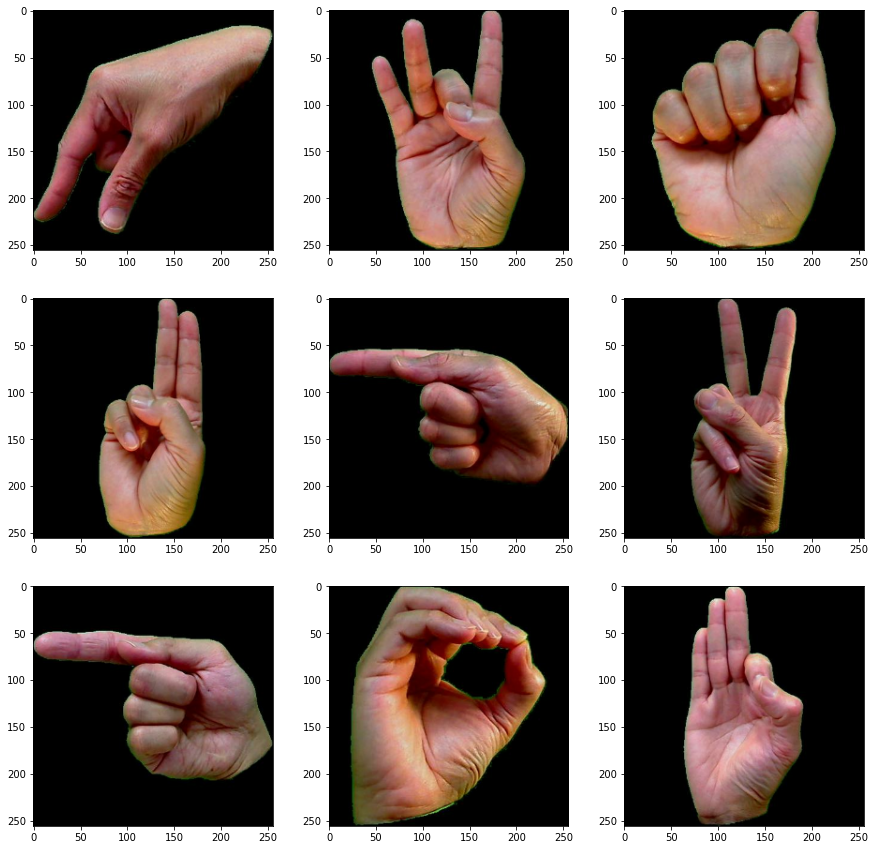

In [68]:

# Define a function to see images
def show_img(data):
    plt.figure(figsize=(15, 15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("on")

# Plot the images in the dataset
show_img(data)

## Training Model - InceptionResNetV2

The code in this cell loads the pre-trained InceptionResNetV2 model, freezes its layers, adds custom layers on top, and compiles the model.

The pre-trained InceptionResNetV2 model is loaded using `tensorflow.keras.applications.InceptionResNetV2` with the weights set to 'imagenet' and the fully connected layers excluded (`include_top=False`). The input shape and pooling type are specified as `img_shape` and 'avg' respectively.

Next, the code freezes the weights of all layers in the pre-trained model by setting their `trainable` attribute to `False`. This ensures that the pre-trained weights are not updated during training.

Custom layers are then added on top of the pre-trained model. Batch normalization is applied to normalize the activations, followed by a fully connected layer with 1024 units and ReLU activation. Dropout with a rate of 0.2 is used to reduce overfitting. The final dense layer with `num_classes` units and softmax activation serves as the output layer for classification.

The model is created by specifying the inputs as the input of the pre-trained model and the outputs as the predictions from the custom layers. The model is compiled using the Adam optimizer with a learning rate of 0.001, 'categorical_crossentropy' as the loss function for multi-class classification, and 'accuracy' as the metric for evaluation.

Finally, the model summary is displayed, showing the architecture of the model, the output shapes of each layer, and the number of parameters in each layer.


In [69]:
# Load pre-trained InceptionResNetV2
pre_trained = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')


219070464/219055592 [==============================] - 10s 0us/step


In [70]:
for layer in pre_trained.layers:
    layer.trainable = False
x = pre_trained.output
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=pre_trained.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 228, 228, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 113, 113, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 113, 113, 32) 96          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 113, 113, 32) 0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

### model fitting

train the model using `fit_generator` with training and validation data generators. It calculate the steps per epoch and validation steps, then train the model for 50(10+40) epochs, displaying progress and metrics. The training history is stored in the `history` variable.

In [71]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
63/63 [==============================] - 50s 641ms/step - loss: 3.1983 - accuracy: 0.3096 - val_loss: 2.8168 - val_accuracy: 0.2147
Epoch 2/10
63/63 [==============================] - 36s 580ms/step - loss: 2.0005 - accuracy: 0.5089 - val_loss: 1.9939 - val_accuracy: 0.4394
Epoch 3/10
63/63 [==============================] - 36s 577ms/step - loss: 1.6701 - accuracy: 0.5616 - val_loss: 1.7764 - val_accuracy: 0.5030
Epoch 4/10
63/63 [==============================] - 36s 572ms/step - loss: 1.5117 - accuracy: 0.6163 - val_loss: 1.6625 - val_accuracy: 0.5527
Epoch 5/10
63/63 [==============================] - 36s 570ms/step - loss: 1.4176 - accuracy: 0.6252 - val_loss: 1.4716 - val_accuracy: 0.5964
Epoch 6/10
63/63 [==============================] - 36s 570ms/step - loss: 1.2580 - accuracy: 0.6556 - val_loss: 1.5785 - val_accuracy: 0.5706
Epoch 7/10
63/63 [==============================] - 36s 566ms/step - loss: 1.1460 - accuracy: 0.6774 - val_loss: 1.4828 - val_accuracy: 0.6004

In [78]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=40
)

Epoch 1/40
63/63 [==============================] - 44s 617ms/step - loss: 0.9832 - accuracy: 0.7237 - val_loss: 1.3840 - val_accuracy: 0.6600
Epoch 2/40
63/63 [==============================] - 36s 566ms/step - loss: 0.9656 - accuracy: 0.7097 - val_loss: 1.5564 - val_accuracy: 0.6521
Epoch 3/40
63/63 [==============================] - 35s 563ms/step - loss: 0.8816 - accuracy: 0.7411 - val_loss: 1.4850 - val_accuracy: 0.6421
Epoch 4/40
63/63 [==============================] - 35s 563ms/step - loss: 0.8969 - accuracy: 0.7361 - val_loss: 1.2382 - val_accuracy: 0.6740
Epoch 5/40
63/63 [==============================] - 35s 563ms/step - loss: 0.9741 - accuracy: 0.7261 - val_loss: 1.4488 - val_accuracy: 0.6600
Epoch 6/40
63/63 [==============================] - 35s 561ms/step - loss: 0.8614 - accuracy: 0.7515 - val_loss: 1.4740 - val_accuracy: 0.6680
Epoch 7/40
63/63 [==============================] - 36s 570ms/step - loss: 0.7401 - accuracy: 0.7709 - val_loss: 1.1782 - val_accuracy: 0.7018

## plotting the graph 

This code plots the training and validation loss and accuracy over the epochs. The loss and accuracy values from the `history` object are used to create line plots. The x-axis represents the epoch number, while the y-axis represents the loss or accuracy. Separate plots are created for training and validation data, and legends are added to differentiate them.

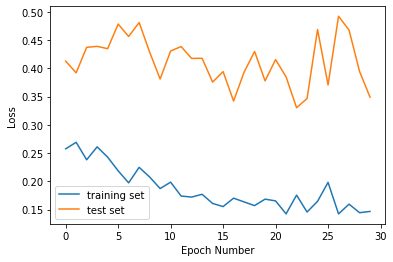

In [50]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

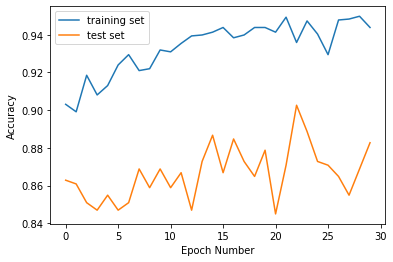

In [51]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

### saving the model 


In [79]:
model_name = 'hand_sign_recognition_InceptionResNetV2.h5'
model.save(model_name, save_format='h5')

In [52]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

### image label and prediction and visualization

In [53]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

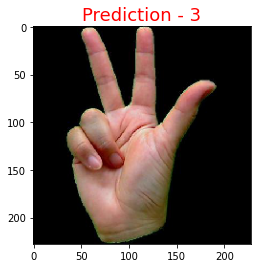

In [88]:
predict_image('/kaggle/input/asl-dataset/asl_dataset/3/hand2_3_top_seg_4_cropped.jpeg', model)

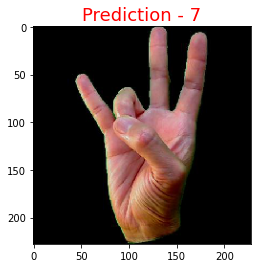

In [89]:
predict_image('/kaggle/input/asl-dataset/asl_dataset/7/hand1_7_left_seg_4_cropped.jpeg', model)

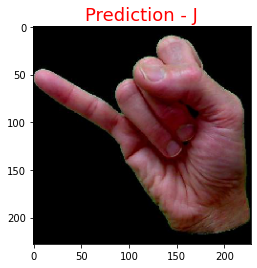

In [90]:
predict_image('/kaggle/input/asl-dataset/asl_dataset/j/hand1_j_dif_seg_1_cropped.jpeg', model)

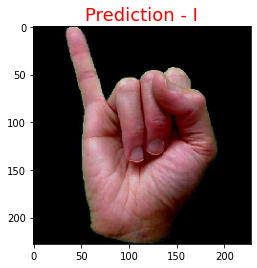

In [91]:
predict_image('/kaggle/input/asl-dataset/asl_dataset/i/hand1_i_dif_seg_4_cropped.jpeg', model)

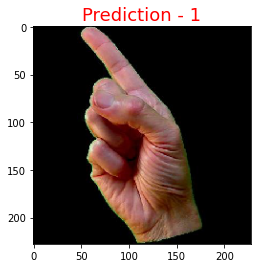

In [92]:
predict_image('/kaggle/input/asl-dataset/asl_dataset/z/hand1_z_left_seg_1_cropped.jpeg', model)

### importing libraries for classification report , accuracy score and confusion matrix

In [80]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
# Load the saved model
model = tf.keras.models.load_model('hand_sign_recognition_InceptionResNetV2.h5')

# Evaluate the model on the original validation data
val_images, val_labels = next(iter(val_data))
val_predictions = model.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(val_labels, axis=1)


###  f1 score

In [82]:
 # Classification Report
print('Classification Report:')
print(classification_report(val_true_labels, val_pred_labels, zero_division=1))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           7       0.00      1.00      0.00         0
           8       1.00      0.00      0.00         1
          11       1.00      1.00      1.00         3
          13       1.00      0.50      0.67         2
          14       0.50      1.00      0.67         1
          15       1.00      1.00      1.00         1
          16       0.50      1.00      0.67         1
          17       1.00      0.50      0.67         2
          18       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         1
          20       1.00      1.00      1.00         2
          21       1.00      1.00      1.00         2
          22       1.00      0.00      0.00         1
          23       0.50      1.00      0.67         1
    

### accuracy score

In [83]:
# Accuracy Score
accuracy = accuracy_score(val_true_labels, val_pred_labels)
print('Accuracy Score:', accuracy)


Accuracy Score: 0.875


### confusion matrix

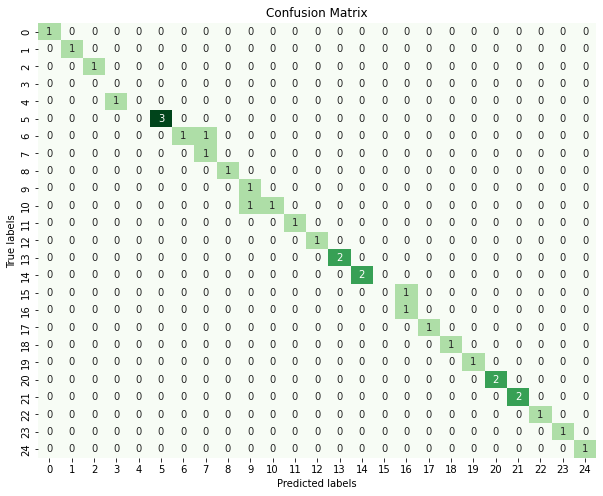

In [84]:
# Confusion Matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
